# Softmax

Avec cet exercice, vous serez appelé à:

- implanter un réseau de neurones de classification linéaire à 10 classes avec sortie **Softmax**
- implanter une fonction de perte (**loss function**) vectorisée de type **entropie croisée**
- implanter des **gradients analytiques rétropropagés** vectorisés
- utilisation de **gradients numériques** pour vérifier vos gradients analytiques
- utiliser un ensemble de validation pour ajuster le **taux d'apprentissage** et le paramètre de **régularisation**
- implanter une descente de gradient stochastique (**SGD**)
- **visualiser** les poids appris


In [22]:
import random
import numpy as np
from ift725.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ift725/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Classifieur Softmax

Le code pour cette section réside dans **ift725/classifiers/softmax.py**. 


In [24]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_naive_loss_function située dans le fichier            #
#  ift725.classifiers.softmax.                                               #
##############################################################################

from ift725.classifiers.softmax import softmax_naive_loss_function
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_naive_loss_function(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.344568
sanity check: 2.302585


## Question 1:
Pourquoi s'attend-on que la loss soit approximativement -np.log(0.1))?

**Votre réponse:**  Un réseau non entraîné devrait avoir une prédiction uniforme pour chaque classe, donc pour 10 classes, 10% devrait être la quantité de bonne prédiction.

In [25]:
##############################################################################
# TODO: Compléter le calcul du gradient de façon naive avec des boucles dans #
#  la fonction softmax_naive_loss_function située dans le fichier            #
#  ift725.classifiers.softmax.                                               #
##############################################################################
loss, grad = softmax_naive_loss_function(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from ift725.gradient_check import check_gradient_sparse
f = lambda w: softmax_naive_loss_function(w, X_dev, y_dev, 0.0)[0]
grad_numerical = check_gradient_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_naive_loss_function(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_naive_loss_function(w, X_dev, y_dev, 1e2)[0]
grad_numerical = check_gradient_sparse(f, W, grad, 10)

numerical: -2.225153 analytic: -2.225153, relative error: 5.445097e-09
numerical: -0.479049 analytic: -0.479049, relative error: 4.458602e-08
numerical: 0.726905 analytic: 0.726905, relative error: 1.798443e-08
numerical: -0.758064 analytic: -0.758064, relative error: 4.605475e-08
numerical: 1.160619 analytic: 1.160619, relative error: 3.467319e-09
numerical: 2.335242 analytic: 2.335242, relative error: 2.022790e-08
numerical: 2.283745 analytic: 2.283745, relative error: 1.378130e-08
numerical: 1.163424 analytic: 1.163424, relative error: 2.819621e-08
numerical: 0.611334 analytic: 0.611334, relative error: 5.577107e-08
numerical: 3.090085 analytic: 3.090085, relative error: 4.751689e-09
numerical: 1.299700 analytic: 1.299783, relative error: 3.180646e-05
numerical: 3.500187 analytic: 3.500187, relative error: 1.417818e-08
numerical: 6.510764 analytic: 6.510793, relative error: 2.217115e-06
numerical: -2.286715 analytic: -2.286700, relative error: 3.338548e-06
numerical: 3.283680 analyt

### Question 2:  
Les 2 prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = \frac{1}{N} \sum \frac{e^{XW}}{\sum e^{XW}} - 1 + R(W)$$

$$dW = \frac{1}{N} X^T \frac{e^{XW}}{\sum e^{XW}} + R^{\prime}(W)$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et ventorielles

In [26]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
#  dans la fonction softmax_vectorized_loss_function située dans le fichier  #
#  ift725.classifiers.softmax.                                               #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être beaucoup plus rapide.                             #
##############################################################################
tic = time.time()
loss_naive, grad_naive = softmax_naive_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print(X_dev.shape)
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from ift725.classifiers.softmax import softmax_vectorized_loss_function
tic = time.time()
loss_vectorized, grad_vectorized = softmax_vectorized_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

(500, 3073)
naive loss: 2.344568e+00 computed in 1.066345s
vectorized loss: 2.344568e+00 computed in 0.044653s
Loss difference: 0.000000
Gradient difference: 0.000000


best acc 0.242000 : lr=0.000000 reg=10000.000000
best acc 0.287000 : lr=0.000000 reg=10000.000000
best acc 0.304000 : lr=0.000000 reg=100000.000000
best acc 0.312000 : lr=0.000000 reg=100000.000000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.231041 val accuracy: 0.242000
lr 1.000000e-07 reg 5.500000e+04 train accuracy: 0.224776 val accuracy: 0.236000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.231041 val accuracy: 0.216000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.265816 val accuracy: 0.287000
lr 2.000000e-07 reg 5.500000e+04 train accuracy: 0.259388 val accuracy: 0.278000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.262388 val accuracy: 0.256000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.273020 val accuracy: 0.273000
lr 3.000000e-07 reg 5.500000e+04 train accuracy: 0.283286 val accuracy: 0.267000
lr 3.000000e-07 reg 1.000000e+05 train accuracy: 0.282122 val accuracy: 0.304000
lr 4.000000e-07 reg 1.000000e+04 train accuracy: 0.287184 val accuracy: 0

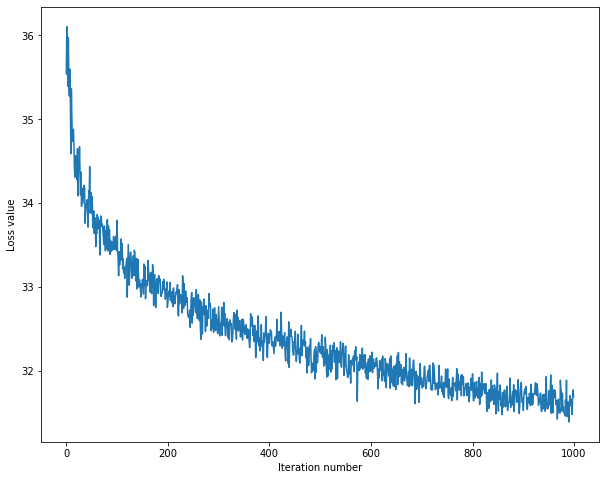

In [28]:
from ift725.classifiers import Softmax
import itertools as it
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(1e-7, 5e-7, 5)
regularization_strengths = np.linspace(1e4, 1e5, 3)
best_loss_history = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si vous êtes prudent, vous devriez       #
#  pouvoir obtenir une précision de classification supérieur à 0.36 sur      #
#  l'ensemble de validation.                                                 #
##############################################################################
for lr, reg in it.product(learning_rates, regularization_strengths):
    classifier = Softmax()
    loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    acc_train = np.mean(y_train == y_train_pred)
    acc_val = np.mean(y_val == y_val_pred)
    results[(lr, reg)] = (acc_train, acc_val)
    
    if acc_val > best_val:
        print('best acc %f : lr=%f reg=%f' %(acc_val, lr, reg))
        best_val = acc_val
        best_softmax = classifier
        best_loss_history = loss_history
################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

plt.plot(best_loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [29]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy) )

softmax on raw pixels final test set accuracy: 0.294000


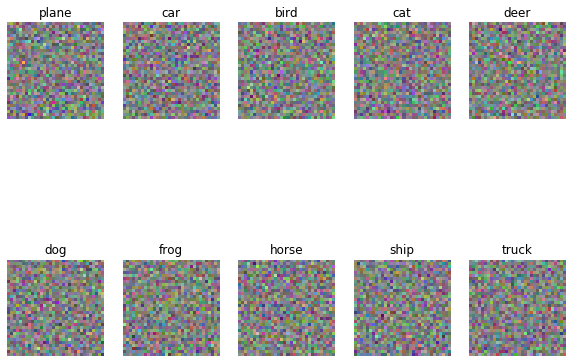

In [30]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])